# Evaluation of Optimization Strategies

Genera una funcion random

encuentra el maximmo  y cantidad de puntos necesaria mediante:

    Sequential
            Bayesian Optimization
            Simplex
    Batch
        least squares
        RBF

In [1]:
import numpy as np
import pandas as pd
from BO_modules import Bay_Opt, Global_Maxima, Global_Minima
from Simplex_module import Simplex_Opt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

### Create Random Quadratic Function
#### Solving with Bayesian Optimization

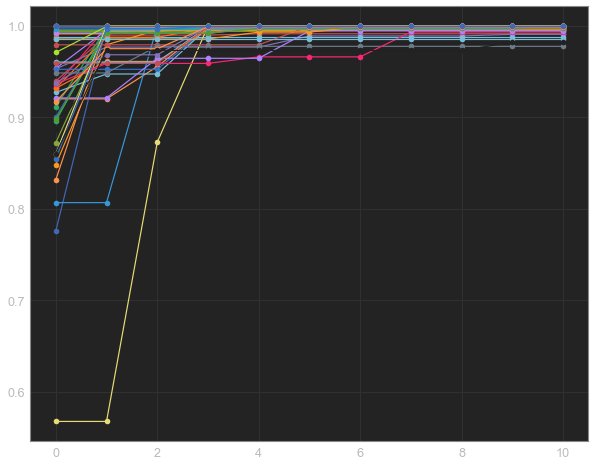

In [2]:
warnings.filterwarnings('ignore')
Nfunc = 50 # number of functions generated
Nweight = 6 # number of coeficients for the function
Npoint = 11 ##numero de puntos para metodos sequenciales nuevos +1
Fmax_BO=np.zeros((Npoint,Nfunc))

np.random.seed(42)

W=np.random.rand(Nfunc,Nweight)*100
F_max=np.zeros((Nfunc,1))
X_max=np.zeros((Nfunc,2))
F_min=np.zeros((Nfunc,1))
X_min=np.zeros((Nfunc,2))

for i in range(Nfunc): 
    # generate random cuadratic functions 
    w=W[i,:]
    def fun(X):
       H = np.transpose([X[0]**2,X[1]**2,X[0]*X[1],X[0],X[1],1])
       return -np.dot(H,w) # el menos es para que sean maximos
    
    bounds =[(-1,1),(-1,1)]
    X_max[i],F_max[i] = Global_Maxima(fun,bounds)
    X_min[i],F_min[i] = Global_Minima(fun,bounds)
    
    def func(X): ## Funcion escalada entre 0 y 1
        return (fun(X)-F_min[i])/(F_max[i]-F_min[i])
    
    #   Bayesian Optimization 
    X_init = np.array([[-1,-1], [1,1],[1,-1],[-1,1]])
    X_new=np.array([0,0])
    
    Y_init=np.zeros(X_init.shape[0])
    for point in range(X_init.shape[0]):
       Y_init[point] = func(X_init[point,:])
    Y_new= func(X_new)
   
    for itr in range(0,Npoint):
        X_init= np.vstack((X_init, X_new))
        Y_init= np.hstack((Y_init, Y_new))
        BO=Bay_Opt(X_init,Y_init,bounds,Acq_Fun = 'EI', epsilon= 0.1)
        Fmax_BO[itr,i]=max(Y_init)
        X_new, muNew=BO.Global_Max()
        Y_new=func(X_new)

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(Fmax_BO,'-o');

<IPython.core.display.Javascript object>


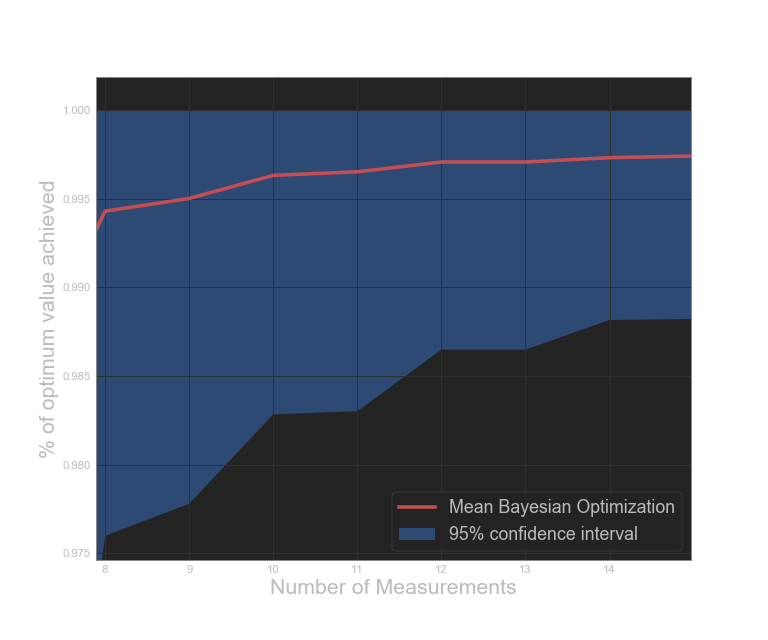

In [138]:
%matplotlib notebook
Fmax_BO.shape
SD=np.std(Fmax_BO,axis=1)
Mean=np.mean(Fmax_BO,axis=1)
NumMeasure = np.linspace(5,4+len(Mean),len(Mean)) 

#plt.rcParams.update({'font.size': 2})
plt.figure(figsize=(12, 10), dpi= 80)
plt.plot(NumMeasure, Mean, 'r', linewidth=4,label=r'Mean Bayesian Optimization')
plt.fill(np.concatenate([NumMeasure, NumMeasure[::-1]]),
          np.concatenate([Mean - 1.9600 * SD,
                         (np.ones(Mean.shape))[::-1]]),
          alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('Number of Measurements', fontsize=24)
plt.ylabel('% of optimum value achieved',fontsize=24)
plt.xlim(1, 15)
plt.legend(loc='lower right',prop={'size':20})
plt.show()
plt.savefig('Bayesian Optimization Performance cuad 2D_w.png', facecolor='w', edgecolor='none',transparent=True)

<IPython.core.display.Javascript object>


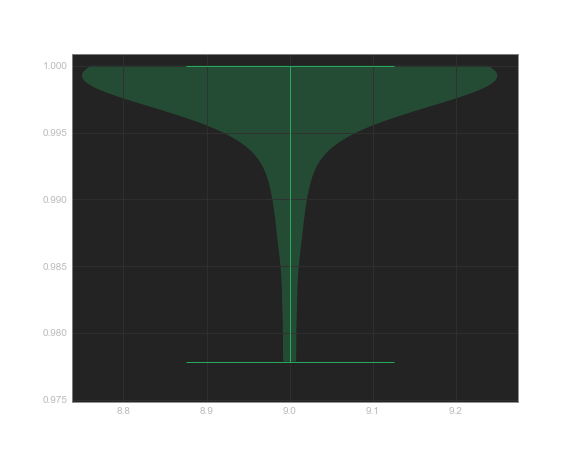

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(1,Fmax_BO.shape[0]):
    ax.violinplot(dataset=Fmax_BO[i,:],positions=[i])

### Create Random Quadratic Function
#### Solving with Simplex

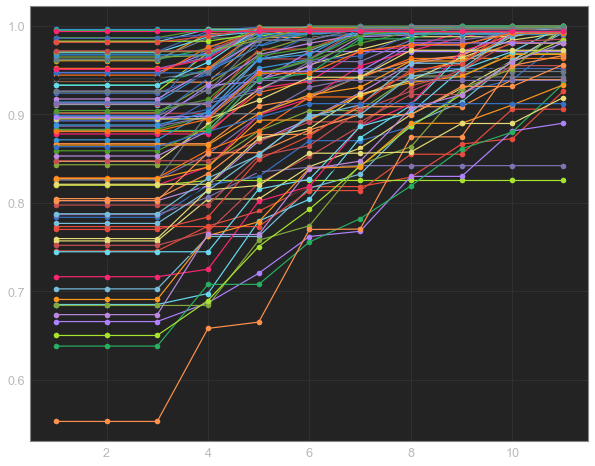

In [5]:
Nfunc = 100 #number of functions generated
Nweight = 6 # number of coeficients for the function
Npoint=10 ##numero de puntos para metodos sequenciales nuevos +1
Fmax_SIM=np.zeros((Npoint+2,Nfunc))

np.random.seed(40)

W=np.random.rand(Nfunc,Nweight)*100
F_max=np.zeros((Nfunc,1))
X_max=np.zeros((Nfunc,2))
F_min=np.zeros((Nfunc,1))
X_min=np.zeros((Nfunc,2))

for i in range(Nfunc): 
    # generate random cuadratic functions 
    w=W[i,:]
    def fun(X):
       H = np.transpose([X[0]**2,X[1]**2,X[0]*X[1],X[0],X[1],1])
       return -np.dot(H,w) # el menos es para que sean maximos
    
    bounds =np.array([(-1,1),(-1,1)])
    bds=[(-1,1),(-1,1)]
    X_max[i],F_max[i] = Global_Maxima(fun,bds)
    X_min[i],F_min[i] = Global_Minima(fun,bds)
    
    def func(X): ## Funcion escalada entre 0 y 1
        return (fun(X)-F_min[i])/(F_max[i]-F_min[i])
    
    #Simplex         
    X0=[0,0]        
    Simplx=Simplex_Opt(X0,Step=0.3)  
    Pinit=Simplx.Initial_Points()
    df=pd.DataFrame(np.hstack((Pinit, func(np.transpose(Pinit)).reshape(-1,1))))
    dfaux=df.copy()

    for itr in range(1,Npoint):
       df.sort_index(inplace=True)
       dfaux.sort_values(dfaux.columns[-1],ascending=False, inplace=True)
       R=Simplx.Simplex(dfaux)
       if R[0]>bounds[0,1]:
            R[0]= bounds[0,1]
       elif  R[0]<bounds[0,0]:
            R[0]= bounds[0,0]
       if R[1]>bounds[1,1]:
            R[1]= bounds[1,1]
       elif  R[1]<bounds[1,0]:
            R[1]= bounds[1,0]     
       R.at[len(X0)]= func(R)
       df.loc[itr+2]=R
       dfaux.iloc[len(X0)]=R


    df.sort_index(inplace=True)
    for jo in range(df.shape[0]):
       Fmax_SIM[jo,i]=(df.iloc[0:jo,2].max())
       #Fmax_SIM[jo,i]=df[0:jo,2].max() 
fig, ax = plt.subplots(figsize=(10, 8));
plt.plot(Fmax_SIM,'-o');

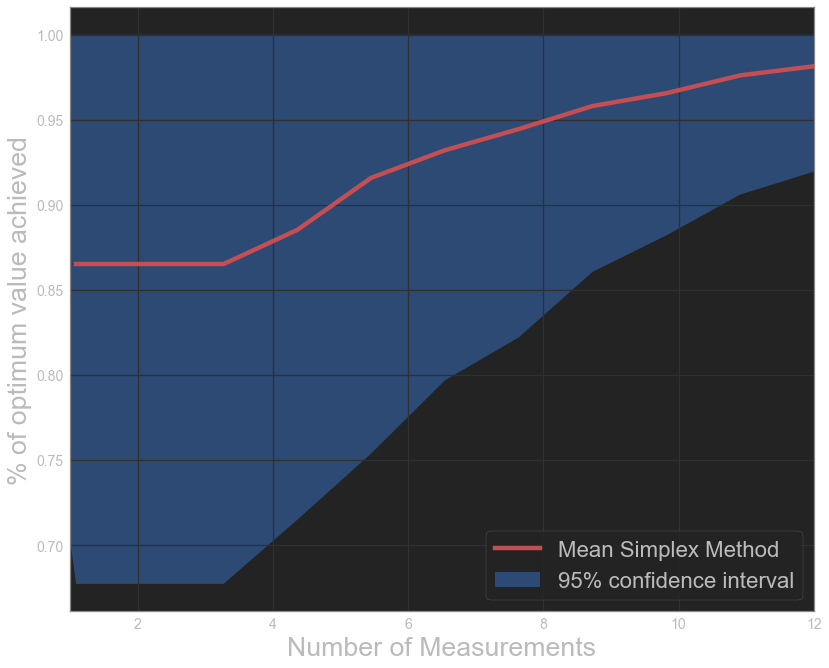

In [6]:
Fmax_SIM.shape
SD_sim=np.std(Fmax_SIM,axis=1)
Mean_sim=np.mean(Fmax_SIM,axis=1)
NumMeasure = np.linspace(0,len(Mean_sim),len(Mean_sim)) 

#plt.rcParams.update({'font.size': 2})
plt.figure(figsize=(12, 10), dpi= 80)
plt.plot(NumMeasure, Mean_sim, 'r', linewidth=4,label=r'Mean Simplex Method')
plt.fill(np.concatenate([NumMeasure, NumMeasure[::-1]]),
          np.concatenate([Mean_sim - 1.9600 * SD_sim,
                         (np.ones(Mean_sim.shape))[::-1]]),
          alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('Number of Measurements', fontsize=24)
plt.ylabel('% of optimum value achieved',fontsize=24)
plt.xlim(1, NumMeasure.max())

plt.legend(loc='lower right',prop={'size':20})
plt.savefig('Simplex Performance cuad 2D.png')

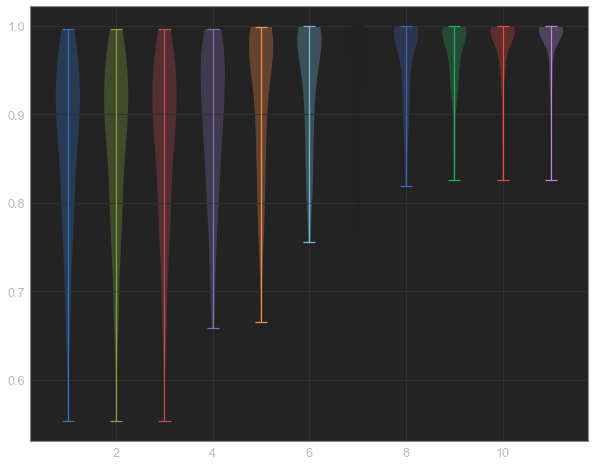

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(1,Fmax_SIM.shape[0]):
    ax.violinplot(dataset=Fmax_SIM[i,:],positions=[i])

### Create Random Quadratic Function
#### Solving with modified Simplex
M.A.Bezerra etal. / MicrochemicalJournal124 (2016) 45 –54

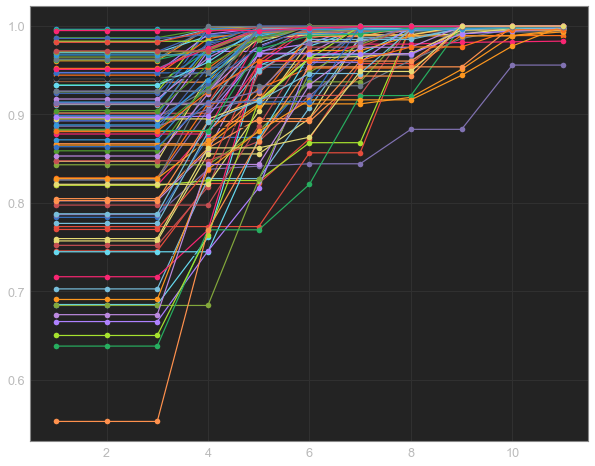

In [8]:
Nfunc = 100 #number of functions generated
Nweight = 6 # number of coeficients for the function
Npoint=10 ##numero de puntos para metodos sequenciales nuevos +1
Fmax_mSIM=np.zeros((Npoint+2,Nfunc))

np.random.seed(40)

W=np.random.rand(Nfunc,Nweight)*100
F_max=np.zeros((Nfunc,1))
X_max=np.zeros((Nfunc,2))
F_min=np.zeros((Nfunc,1))
X_min=np.zeros((Nfunc,2))

for i in range(Nfunc): 
    # generate random cuadratic functions 
    w=W[i,:]
    def fun(X):
       H = np.transpose([X[0]**2,X[1]**2,X[0]*X[1],X[0],X[1],1])
       return -np.dot(H,w) # el menos es para que sean maximos
    
    bounds =np.array([(-1,1),(-1,1)])
    bds=[(-1,1),(-1,1)]
    X_max[i],F_max[i] = Global_Maxima(fun,bds)
    X_min[i],F_min[i] = Global_Minima(fun,bds)
    
    def func(X): ## Funcion escalada entre 0 y 1
        return (fun(X)-F_min[i])/(F_max[i]-F_min[i])
    
    #Simplex         
    X0=[0,0]        
    Simplx=Simplex_Opt(X0,Step=0.3)  
    Pinit=Simplx.Initial_Points()
    df=pd.DataFrame(np.hstack((Pinit, func(np.transpose(Pinit)).reshape(-1,1))))
    dfaux=df.copy()

    for itr in range(1,Npoint):
       df.sort_index(inplace=True)
       dfaux.sort_values(dfaux.columns[-1],ascending=False, inplace=True)
       R=Simplx.Simplex_Mod(dfaux,func)
       if R[0]>bounds[0,1]:
            R[0]= bounds[0,1]
       elif  R[0]<bounds[0,0]:
            R[0]= bounds[0,0]
       if R[1]>bounds[1,1]:
            R[1]= bounds[1,1]
       elif  R[1]<bounds[1,0]:
            R[1]= bounds[1,0]     
       R.at[len(X0)]= func(R)
       df.loc[itr+2]=R
       dfaux.iloc[len(X0)]=R


    df.sort_index(inplace=True)
    for jo in range(df.shape[0]):
       Fmax_mSIM[jo,i]=(df.iloc[0:jo,2].max())
       #Fmax_SIM[jo,i]=df[0:jo,2].max() 
fig, ax = plt.subplots(figsize=(10, 8));
plt.plot(Fmax_mSIM,'-o');

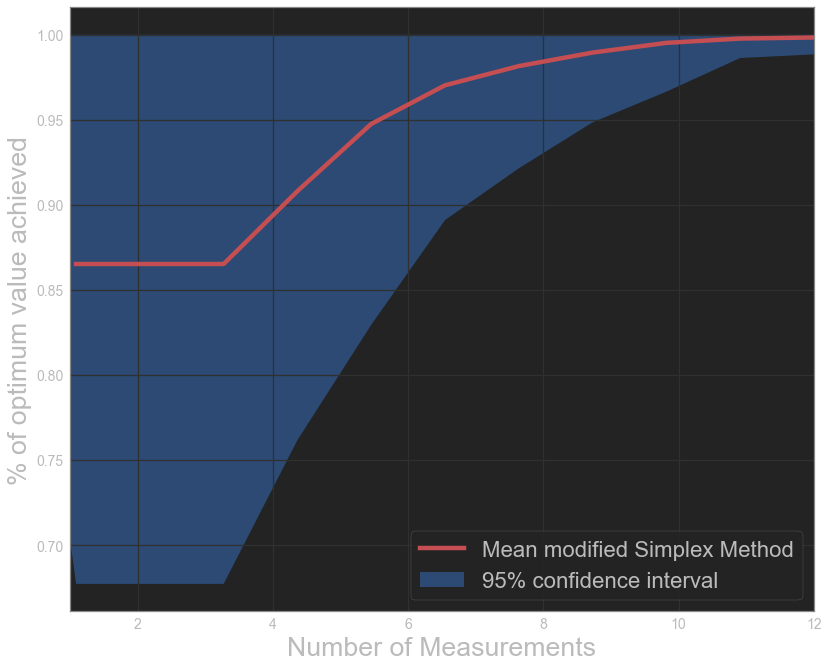

In [9]:
Fmax_mSIM.shape
SD_msim=np.std(Fmax_mSIM,axis=1)
Mean_msim=np.mean(Fmax_mSIM,axis=1)
NumMeasure = np.linspace(0,len(Mean_msim),len(Mean_msim)) 

#plt.rcParams.update({'font.size': 2})
plt.figure(figsize=(12, 10), dpi= 80)
plt.plot(NumMeasure, Mean_msim, 'r', linewidth=4,label=r'Mean modified Simplex Method')
plt.fill(np.concatenate([NumMeasure, NumMeasure[::-1]]),
          np.concatenate([Mean_msim - 1.9600 * SD_msim,
                         (np.ones(Mean_msim.shape))[::-1]]),
          alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('Number of Measurements', fontsize=24)
plt.ylabel('% of optimum value achieved',fontsize=24)
plt.xlim(1, NumMeasure.max())

plt.legend(loc='lower right',prop={'size':20})
plt.savefig('Modified Simplex Performance cuad 2D.png')

### Create Random Quadratic Function
####  Solving with Least Squares
  Using sklearn

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


{'bodies': [<matplotlib.collections.PolyCollection at 0x218e8e0d608>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x218e94d8a48>,
 'cmins': <matplotlib.collections.LineCollection at 0x218e8e0d188>,
 'cbars': <matplotlib.collections.LineCollection at 0x218e8e0d588>}

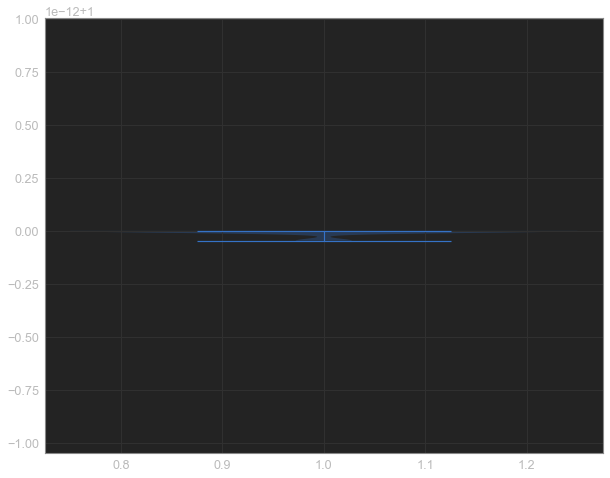

In [126]:
from pyDOE import *

from sklearn import linear_model

Nfunc = 10 #number of functions generated
Nweight = 6 # number of coeficients for the function
#Npoint=10 ##numero de puntos para metodos sequenciales nuevos +1
#Fmax_mSIM=np.zeros((Npoint+2,Nfunc))

# Central Composite Design (CCD)
x=ccdesign(2,center=(0,1), face='cci')

# full factorial:
#x=fullfact([5,5])/2-1

np.random.seed(40)

W=np.random.rand(Nfunc,Nweight)*100
F_max=np.zeros((Nfunc,1))
X_max=np.zeros((Nfunc,2))
Fp_max=np.zeros((Nfunc,1))
Xp_max=np.zeros((Nfunc,2))
F_min=np.zeros((Nfunc,1))
X_min=np.zeros((Nfunc,2))
z=np.zeros(x.shape[0])
LS_max=np.zeros((Nfunc,1))

for i in range(Nfunc): 
    # generate random cuadratic functions 
    w=W[i,:]
    def fun(X):
       H = np.transpose([X[0]**2,X[1]**2,X[0]*X[1],X[0],X[1],1])
       return -np.dot(H,w) # el menos es para que sean maximos
    
    bounds =np.array([(-1,1),(-1,1)])
    bds=[(-1,1),(-1,1)]
    X_max[i],F_max[i] = Global_Maxima(fun,bds)
    X_min[i],F_min[i] = Global_Minima(fun,bds)
    
    def func(X): ## Funcion escalada entre 0 y 1
        return (fun(X)-F_min[i])/(F_max[i]-F_min[i])
    
    #solve whith LS
    #Initialize the linear regression model
    reg = linear_model.LinearRegression()
    h = np.transpose(np.vstack((x[:,0].reshape(-1,), x[:,1].reshape(-1,),x[:,0].reshape(-1,)**2,x[:,1].reshape(-1,)**2,x[:,0].reshape(-1,)*x[:,1].reshape(-1,))))
    
    for pts in range(len(x)): 
        z[pts] = func(x[pts,:])
    #print(h)
    reg.fit(h, z)
    
    def pred(X):#prediction function
        H = np.transpose(np.vstack((X[0],X[1],X[0]**2,X[1]**2,X[0]*X[1])))
        return reg.predict(H)
    
    #print(pred(X_max[0]))
    Xp_max[i],Fp_max[i] = Global_Maxima(pred,bds)
    LS_max[i]=func(Xp_max[i])
    #print(np.hstack((X_max,Xp_max))) 
#print(pred([X_max[0,:],X_max[0,1]]),pred([Xp_max[0,0],Xp_max[0,1]]))
#print(func([X_max[0,0],X_max[0,1]]),func([Xp_max[0,0],Xp_max[0,1]]))
#print(np.hstack((F_max,Fp_max)))  
#print(reg.coef_,w)
print(LS_max)
fig, ax = plt.subplots(figsize=(10, 8));
ax.violinplot(dataset=LS_max);

### Create Random Quadratic Function
####  Solving with Radial Basis Functions
  Using Scipy

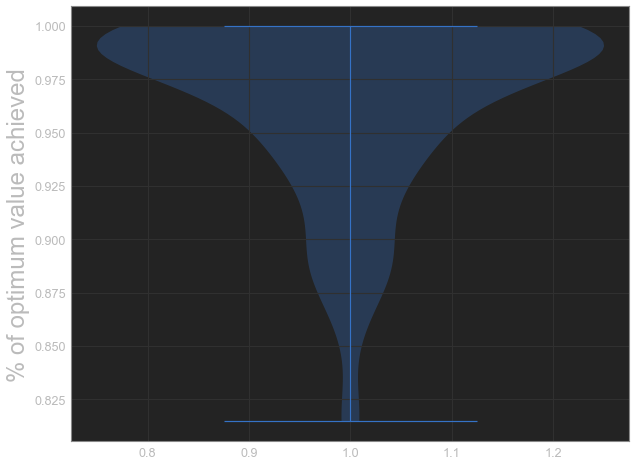

In [130]:
from pyDOE import *
from scipy import interpolate
%matplotlib inline

Nfunc = 100 #number of functions generated
Nweight = 6 # number of coeficients for the function
#Npoint=10 ##numero de puntos para metodos sequenciales nuevos +1
#Fmax_mSIM=np.zeros((Npoint+2,Nfunc))

# Central Composite Design (CCD)
x=ccdesign(2,center=(0,1),face='cci')

# full factorial:
#x=fullfact([5,5])/2-1

np.random.seed(40)

W=np.random.rand(Nfunc,Nweight)*100
F_max=np.zeros((Nfunc,1))
X_max=np.zeros((Nfunc,2))
Fp_max=np.zeros((Nfunc,1))
Xp_max=np.zeros((Nfunc,2))
F_min=np.zeros((Nfunc,1))
X_min=np.zeros((Nfunc,2))
z=np.zeros(x.shape[0])
RBF_max=np.zeros((Nfunc,1))

for i in range(Nfunc): 
    # generate random cuadratic functions 
    w=W[i,:]
    def fun(X):
       H = np.transpose([X[0]**2,X[1]**2,X[0]*X[1],X[0],X[1],1])
       return -np.dot(H,w) # el menos es para que sean maximos
    
    bounds =np.array([(-1,1),(-1,1)])
    bds=[(-1,1),(-1,1)]
    X_max[i],F_max[i] = Global_Maxima(fun,bds)
    X_min[i],F_min[i] = Global_Minima(fun,bds)
    
    def func(X): ## Funcion escalada entre 0 y 1
        return (fun(X)-F_min[i])/(F_max[i]-F_min[i])
          
    for pts in range(len(x)): 
        z[pts] = func(x[pts,:])
    
    #print(z.shape,x[:,0].shape,x[:,1].shape)
    #solve whith RBF
    RBF= interpolate.Rbf(x[:,0],x[:,1],z,function='gaussian') # multiquadric , gaussian
    
    def RBF_pred(X):#prediction function
        return RBF(X[0],X[1])
    
    #print(pred(X_max[0]))
    Xp_max[i],Fp_max[i] = Global_Maxima(RBF_pred,bds)
    
    RBF_max[i]=func(Xp_max[i])
#print(np.hstack((X_max,Xp_max))) 
#print(pred([X_max[0,0],X_max[0,1]]),pred([Xp_max[0,0],Xp_max[0,1]]))
#print(func([X_max[0,0],X_max[0,1]]),func([Xp_max[0,0],Xp_max[0,1]]))
  
fig, ax = plt.subplots(figsize=(10, 8));
ax.violinplot(dataset=RBF_max);
plt.ylabel('% of optimum value achieved',fontsize=24)
plt.savefig('CCD_RBF Performance cuad 2D.png')

[0.66419918 0.58122327]


<IPython.core.display.Javascript object>


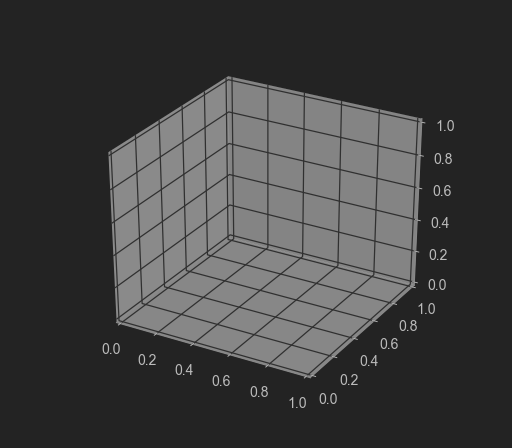

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [69]:
# from mpl_toolkits.mplot3d import Axes3D
# Xsmooth=np.linspace(-1,1,100)
# Ysmooth=np.linspace(-1,1,100)
# xx,yy=np.meshgrid(Xsmooth,Ysmooth)
# Xt=np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))

# Z0 = func(Xt)
# Zp = pred(Xt)

# %matplotlib notebook
# print(z)
# fig =plt.figure()
# ax=fig.gca(projection='3d')
# ax.scatter(x[:,0].reshape(-1,),x[:,1].reshape(-1,),func(x).reshape(-1,),color='r')
# ax.plot_surface(xx,yy,Zp.reshape(xx.shape))

In [11]:
#function visualization auxiliar


# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
# Nfunc =10 #number of functions generated
# Nweight = 6 # number of coeficients for the function
# Npoint=10 ##numero de puntos para metodos sequenciales nuevos +1
# Fmax_SIM=np.zeros((Npoint+2,Nfunc))

# np.random.seed(46)

# Xsmooth=np.linspace(-1,1,100)
# Ysmooth=np.linspace(-1,1,100)
# xx,yy=np.meshgrid(Xsmooth,Ysmooth)

# x=np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))
# z=np.zeros(x.shape)

# W=np.random.rand(Nfunc,Nweight)*100
# F_max=np.zeros((Nfunc,1))
# X_max=np.zeros((Nfunc,2))
# F_min=np.zeros((Nfunc,1))
# X_min=np.zeros((Nfunc,2))

# for i in range(1,2): 
#     # generate random cuadratic functions 
#     w=W[i,:]
#     def fun(X):
#        H = np.transpose([X[0]**2,X[1]**2,X[0]*X[1],X[0],X[1],1])
#        return -np.dot(H,w) # el menos es para que sean maximos
    
#     bounds =np.array([(-1,1),(-1,1)])
#     bds=[(-1,1),(-1,1)]
#     X_max[i],F_max[i] = Global_Maxima(fun,bds,nseeds=30)
#     X_min[i],F_min[i] = Global_Minima(fun,bds,nseeds=40)
    
#     def func(X): ## Funcion escalada entre 0 y 1
#         return (fun(X)-F_min[i])/(F_max[i]-F_min[i])
    
#     for zzz in range(len(x)):
#         z[zzz]=func(x[zzz,:])
#     z=z[:,0]
    
#     fig =plt.figure()
#     ax=fig.gca(projection='3d')
#     ax.scatter(X_min[i,0],X_min[i,1],0,color='r')
#     ax.scatter(X_max[i,0],X_max[i,1],1,color='g')
    
# #     print(func(x[0,:]))
#     ax.plot_surface(xx,yy,z.reshape(100,100))
